# Data Exploration
#### For the Natural Language Inference component
Natural language inference (a.k.a. textual entailment) is a downstream NLP task that classifies whether two sentences are related to one another. In the fact verification system, this task is used to classify whether the ***claim*** is supported by the ***evidence*** returned by the search engine.

### Before We Start

This dataset analysis is for the final component of the fact verification system. We have a raw dataset of wikipedia sentences stored in a SQL database with the fields _page\_id_, _sent\_idx_ and _sentence_. A **train.json** file with raw claims and pointers to the SQL database to query for the evidence exists separately.

### 1. Class distribution
In this section we will take a look at the class distribution and mainly check for whether we have a balanced dataset.

We will take a quick peak at the **train.json** pointers file and convert it into a pandas dataframe.

Note: ***pointer*** file here is just to make the distinguishment that the **evidence** column contains array of pointers that points to the _page\_id_ and _sent\_idx_ stored in a database.

In [1]:
import pandas as pd
import json

with open('train.json', 'r') as f:
    j = json.load(f)
    
df = pd.DataFrame(j.values())
# evidence columns contain multiple elements that should each be an example
df = df.explode('evidence') 
print("Dataset size: {}\n".format(len(df)))
df.head()

Dataset size: 239680



,claim,label,evidence
0,Nikolaj Coster-Waldau worked with the Fox Broa...,SUPPORTS,"[Fox_Broadcasting_Company, 0]"
0,Nikolaj Coster-Waldau worked with the Fox Broa...,SUPPORTS,"[Nikolaj_Coster-Waldau, 7]"
1,Roman Atwood is a content creator.,SUPPORTS,"[Roman_Atwood, 1]"
1,Roman Atwood is a content creator.,SUPPORTS,"[Roman_Atwood, 3]"
2,"History of art includes architecture, dance, s...",SUPPORTS,"[History_of_art, 2]"


Now let's plot the class distribution.

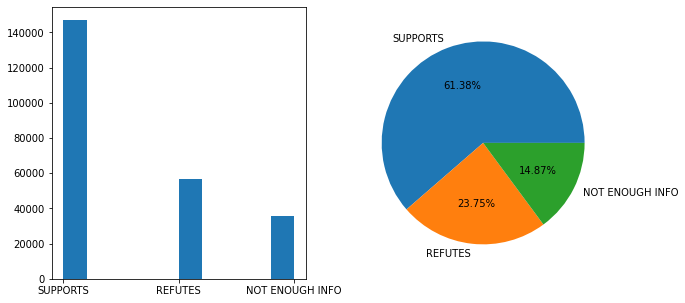

In [2]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
axes[0].hist(df['label'])

label_counts = df['label'].value_counts()
axes[1].pie(label_counts, labels=label_counts.index, autopct="%.2f%%")
fig.show()

### Analysis:

#### Imbalance classes
The **class distribution is clearly imbalanced** with 61.38% of the dataset consisting of SUPPORTS examples. This can become a problem during evaluation because a good accuracy may just be reflecting the underlying class distribution (a.k.a. the [accuracy paradox](https://en.wikipedia.org/wiki/Accuracy_paradox)). To reiterate, if you imagine the dataset to be even more skewed, say 90%, a classifier that only output SUPPORTS will have a 90% accuracy.

#### Missing values
We will drop the rows with the target NOT ENOUGH INFO since they have no evidence. The key words for this problem is **missing value**. 

#### Upsampling
Alternatively, we can convert the NOT ENOUGH INFO examples to REFUTES to counter act the imbalance, (i.e. **Upsampling**). A method we can use is **missing value imputation**, we can sample (without replacement) an evidence (i.e. _sentence_) from the database and then ensure both the claim and the sampled evidence does not share any of the same tokens (stop words excluded) and [named entities](https://spacy.io/api/annotation#named-entities), if not, we will resample.

#### Downsampling
However, these heuristics can still introduce incorrect data into the dataset. Since we have a relatively large number of REFUTES examples, we can instead use **Downsampling** and sample a subset of SUPPORTS examples equivalent to the size of REFUTES.

In [3]:
# removing NOT ENOUGH INFO
mask = df['label'] != 'NOT ENOUGH INFO'
df = df[mask]
label = df['label'].value_counts()

SUPPORTS    56930
REFUTES     56930
Name: label, dtype: int64

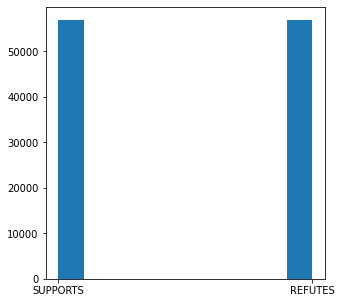

In [4]:
# downsampling dataset
df_s = df[df['label'] == 'SUPPORTS']
df_r = df[df['label'] == 'REFUTES']

num_supports = len(df_r)
df_s = df_s.sample(n=num_supports, random_state=44)
df_balanced = pd.concat([df_s, df_r])

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))
ax.hist(df_balanced['label'])
fig.show()

df_balanced['label'].value_counts()

### 2. Frequencies of tokens in claims
Here we will look at:

**Tokens:**
- top 20 most frequent tokens in claims 

**page_id:**
- the 10 most frequent _page\_id_

In [5]:
# progress bar
from tqdm.notebook import tqdm
tqdm.pandas()

/root/miniconda3/envs/pytorch/lib/python3.7/site-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [23]:
# most frequent tokens in claim
import os; import pandas as pd
csv_path = 'train_balanced_with_claim_tokens.csv'
if os.path.exists(csv_path):
    from ast import literal_eval
    df = pd.read_csv(csv_path, converters={'evidence':literal_eval, 'claim_tokens': literal_eval})
else:
    import nltk
    from nltk.tokenize import word_tokenize
    df['claim_tokens'] = df.progress_apply(lambda row: word_tokenize(row['claim']), axis=1)
df.head()

,Unnamed: 0,claim,label,evidence,claim_tokens
0,0,Nikolaj Coster-Waldau worked with the Fox Broa...,SUPPORTS,"[Fox_Broadcasting_Company, 0]","[Nikolaj, Coster-Waldau, worked, with, the, Fo..."
1,0,Nikolaj Coster-Waldau worked with the Fox Broa...,SUPPORTS,"[Nikolaj_Coster-Waldau, 7]","[Nikolaj, Coster-Waldau, worked, with, the, Fo..."
2,1,Roman Atwood is a content creator.,SUPPORTS,"[Roman_Atwood, 1]","[Roman, Atwood, is, a, content, creator, .]"
3,1,Roman Atwood is a content creator.,SUPPORTS,"[Roman_Atwood, 3]","[Roman, Atwood, is, a, content, creator, .]"
4,2,"History of art includes architecture, dance, s...",SUPPORTS,"[History_of_art, 2]","[History, of, art, includes, architecture, ,, ..."


In [9]:
# df.to_csv('train_balanced_with_claim_tokens.csv')

In [10]:
from collections import Counter
counter = Counter()
for tokens in df['claim_tokens']:
    tokens = [token.lower() for token in tokens]
    counter.update(tokens)

counter.most_common(5)

[('.', 204721), ('a', 85709), ('is', 78362), ('the', 67341), ('in', 53308)]

As expected, the most common words are stop words and punctuations. However, they don't tell us much about the data we have, so let's filter them.

In [11]:
import nltk; nltk.download('stopwords')
from nltk.corpus import stopwords; 
stopwords = set(stopwords.words('english'))
import string

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [12]:
buffer = 50
top = 20
i = 0
most_common = counter.most_common(buffer)
most_common_without_stopwords = []

filters = stopwords.union(set(string.punctuation))

while len(most_common_without_stopwords) <= top or i < buffer:
    token = most_common[i][0]
    if token not in filters:
        most_common_without_stopwords.append(most_common[i])
    i += 1

print("Top 3 most common after filtering:")
most_common_without_stopwords[:3]

Top 3 most common after filtering:


[('film', 16309), ("'s", 10010), ('american', 7873)]

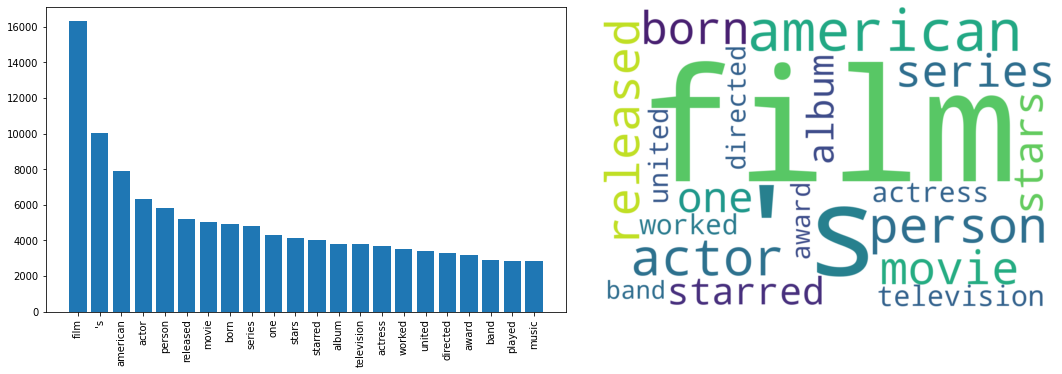

In [20]:
# bar plot
x = [t for (t, c) in most_common_without_stopwords]
y = [c for (t, c) in most_common_without_stopwords]
import matplotlib.pyplot as plt
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
axes[0].bar(x, y)
plt.sca(axes[0])
plt.xticks(x, rotation='vertical')
# fig.show()

# Here's a word cloud for you.
from wordcloud import WordCloud; 
wc = WordCloud(width=1200, height=800, background_color="white", max_words=20)
wc.generate_from_frequencies(dict(most_common_without_stopwords))
# fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))
plt.sca(axes[1])
plt.imshow(wc, interpolation='bilinear')
# plt.title("Word Cloud")
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

In [31]:
# Most common page_ids
df['evidence'].head()[0][0]
df_page_ids = df['evidence'].progress_apply(lambda row: row[0])

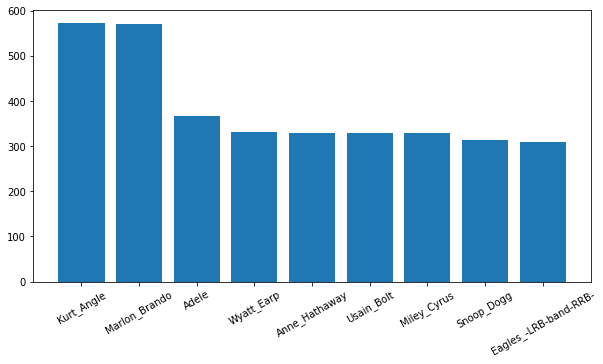

In [48]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))

y = df_page_ids.value_counts(sort=True)[:9].values
x = df_page_ids.value_counts(sort=True)[:9].index
plt.xticks(rotation=30)

axes.bar(x, y)
fig.show()

### Analysis:

The words 'film', 'american', 'actor', 'movie', 'series', 'television', 'actress' are amongst the most frequent tokens in the claims. The ten most frequent _page\_ids_ in the **evidence** column are also filled with American actors and singers. This suggest a reoccuring theme of American movies and entertainment in the dataset. 

This domain consist of simpler sentences because the pages are mostly of a PERSON's profile or a MOVIE's profile. In these wikipedia pages, for example in [Robert Downey Junior](https://en.wikipedia.org/wiki/Robert_Downey_Jr.), sentences such as _"Robert John Downey Jr. (born April 4, 1965)is an American actor, producer, and singer."_ are found. The words _'actor'_, _'producer'_, _'singer'_, or _'Robert John Downey Jr.'_ can all be understood without additional context and can be considered placeholders for more atomic concepts such as a _person_ or a _job_. Here, the highest complexity is the adjective, _"American"_, which may in fact help the model due to giving the word _'actor'_ a higher specificity. 

This contrasts with say the first sentence in the wikipedia page about [Trigonometry](https://en.wikipedia.org/wiki/Outline_of_trigonometry), _"Trigonometry is a branch of mathematics that studies the relationships between the sides and the angles in triangles."_. Input claims related to more abstract or complex concepts such as this may require our model to understand the context of _'triangles'_ having _sides_ and _angles_, as well as the fact that they join together.

As such we can expect the system to behave more accurately given input claims of the same domain or domains that consist of simpler day to day concepts. Another thing of note is that this dataset may introduce bias into the system for having it infer a context of american entertainment when an input claim is ambiguous.

#